In [1]:
RANDOM_STATE = 3956

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

In [4]:
class TransformerStep(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X):
        raise NotImplementedError("transform method should be implemented!")

In [5]:
class OmitColumns(TransformerStep):
    def __init__(self, columns, pipeline):
        self.columns = columns
        self.pipeline = pipeline
        self.preserved_columns = None
        self.rest_columns = None
    def fit(self, X, y=None, **fit_params):
        self.preserved_columns = list(set(X.columns).intersection(self.columns))
        self.rest_columns = list(set(X.columns).difference(self.preserved_columns))
        self.pipeline.fit(X.loc[:, self.rest_columns], y, **fit_params)
        return self
    def transform(self, X):
        preserved_X = X.loc[:, self.preserved_columns]
        processed_X = self.pipeline.transform(X.loc[:, self.rest_columns])
        
        concatenated = pd.concat([processed_X, preserved_X], axis=1).loc[:, X.columns]
        return concatenated

In [6]:
class PerColumnsStackRest(TransformerStep):
    def __init__(self, *columns_pipeline_map):
        self.columns_pipeline_map = columns_pipeline_map
    def fit(self, X, y=None, **fit_params):
        for columns, pipeline in self.columns_pipeline_map:
            pipeline.fit(X.loc[:, columns], y, **fit_params)
        return self
    def transform(self, X):
        processed = []
        rest_columns = set(X.columns)
        for columns, pipeline in self.columns_pipeline_map:
            processed.append(pipeline.transform(X.loc[:, columns]))
            rest_columns -= set(columns)
        if rest_columns:
            processed.append(X.loc[:, rest_columns])
        concatenated = pd.concat(processed, axis=1)
        return concatenated

In [7]:
class ZerosToAgg(TransformerStep):
    def __init__(self, agg=np.median):
        self.central = 0
        self.agg = agg
    def fit(self, X, y=None, **fit_params):
        zeros = (X == 0).values
        self.central = self.agg(X[~zeros])
        return self
    def transform(self, X):
        res = X.copy()
        res_zeros = (res == 0).values
        res[res_zeros] = self.central
        return res

In [8]:
class ZerosToHistogram(TransformerStep):
    def __init__(self):
        self.generator = None
    def fit(self, X, y=None, **fit_params):
        zeros = (X == 0).values
        self.generator = sp.stats.rv_histogram(np.histogram(X[~zeros]))
        return self
    def transform(self, X):
        res = X.copy()
        res_zeros = (res == 0).values
        res[res_zeros] = self.generator.rvs(size=res_zeros.shape, random_state=RANDOM_STATE)
        return res

In [9]:
class VectorizedTransformer(TransformerStep):
    def __init__(self, step_class, *args, **kwargs):
        self.step_class = step_class
        self.step_args = args
        self.step_kwargs = kwargs
        self.step_per_col = []
    def fit(self, X, y=None, **fit_params):
        for col in X.columns:
            step = self.step_class(*self.step_args, **self.step_kwargs)
            step.fit(X.loc[:, [col]], y, **fit_params)
            self.step_per_col.append(step)
        return self
    def transform(self, X):
        assert len(X.columns) == len(self.step_per_col)
        res = []
        for i, col in enumerate(X.columns):
            res.append(self.step_per_col[i].transform(X.loc[:, [col]]))
        return pd.concat(res, axis=1)

In [10]:
class DropColumnsStep(TransformerStep):
    """ This step should come the earliest. Otherwise, previous steps might learn wrong column structure """
    def __init__(self, column_names_to_drop=None):
        self.raw_column_names = column_names_to_drop if column_names_to_drop is not None else []
        self.column_names_to_drop = []
    def fit(self, X, y=None, **fit_params):
        self.column_names_to_drop = list(set(X.columns).intersection(self.raw_column_names))
        return self
    def transform(self, X):
        return X.drop(columns=self.column_names_to_drop)

In [11]:
class DataFrameStep(TransformerStep):
    def __init__(self, step):
        self.step = step
    def fit(self, X, y=None, **fit_params):
        self.step.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        transformed = self.step.transform(X)
        return pd.DataFrame(transformed, index=X.index, columns=X.columns)

In [12]:
class PoissonToNormal(TransformerStep):
    """ https://en.wikipedia.org/wiki/Anscombe_transform """
    def transform(self, X):
        return 2*np.sqrt(X + 3/8)

In [13]:
class ExpToNormal(TransformerStep):
    def __init__(self):
        self.mean = 0
    def fit(self, X, y=None, **fit_params):
        self.mean = sp.median(X, axis=0)
        return self
    def transform(self, X):
        uniform = 1 - np.exp(-X/self.mean)
        normal = np.sqrt(2)*sp.special.erfinv(2*uniform - 1)
        return normal

In [14]:
class DebugStep(TransformerStep):
    def fit(self, X, y=None, **fit_params):
        import ipdb; ipdb.set_trace();
        return self
    def transform(self, X):
        import ipdb; ipdb.set_trace();
        return X

In [15]:
def add_copies(X, col_name, col_value, fraction):
    col = X[col_name]
    replace = fraction > 1
    col_fake = col[col.values == col_value].sample(frac=fraction, random_state=RANDOM_STATE, replace=replace)
    return pd.concat([X, X.loc[col_fake.index]])

In [16]:
def model_report(model, X_test, y_test):
    print(f"Score: {f1_score(model.predict(X_test), y_test)}")
    
    confusion = confusion_matrix(y_test, model.predict(X_test))
    print("Confusion matrix:")
    display(confusion)
    
    
    print("Precision recall fscore support:")
    prfs = precision_recall_fscore_support(y_test, model.predict(X_test))
    display(prfs)
    
    print("Model params")
    if hasattr(model, "best_params_"):
        display(model.best_params_)
    else:
        display(model.get_params())
    
    if hasattr(model, "cv_results_"):
        compiled = [pd.DataFrame(model.cv_results_["mean_test_score"], columns=["mean_test_score"]),
                    pd.DataFrame(model.cv_results_["std_test_score"], columns=["std_test_score"]),
                    pd.DataFrame(model.cv_results_["params"]).add_prefix("param__")]
        compiled_df = pd.concat(compiled, axis=1)
        
        print("All score-params:")
        display(compiled_df)

## Raw data overview

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2f5b52898>,
      dtype=object)

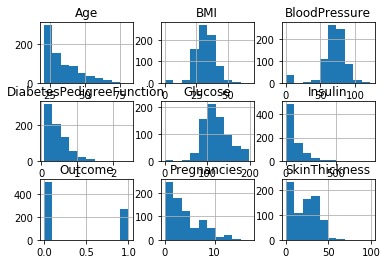

In [17]:
data = pd.read_csv("data/pima.csv")
display(data.head())
display(data.describe())
display(data.hist())

## Define features pipeline

In [18]:
def split_data(data):
    return data.drop(columns=["Outcome"]), data["Outcome"]

In [19]:
def preprocess_training_data(X, y):
    raw_data = pd.concat([X, y], axis=1)
    processed_data = add_copies(raw_data, "Outcome", 1, fraction=1.1)
    X_processed = processed_data.drop(columns=[y.name])
    y_processed = processed_data[y.name]
    return X_processed, y_processed

In [20]:
features_pipeline = lambda: make_pipeline(
    DropColumnsStep(["Insulin"]),
    PerColumnsStackRest(
        (['BloodPressure', 'BMI', 'Glucose'],
         VectorizedTransformer(lambda: ZerosToHistogram()))
    ),
    OmitColumns(["Outcome"],
    VectorizedTransformer(lambda: DataFrameStep(StandardScaler(copy=True, with_mean=False, with_std=True))))
)

In [21]:
def transformed(data):
    X_raw, y_raw = split_data(data)
    X, y = preprocess_training_data(X_raw, y_raw)
    X_processed = features_pipeline().fit_transform(X)
    return pd.concat([X_processed, y], axis=1)

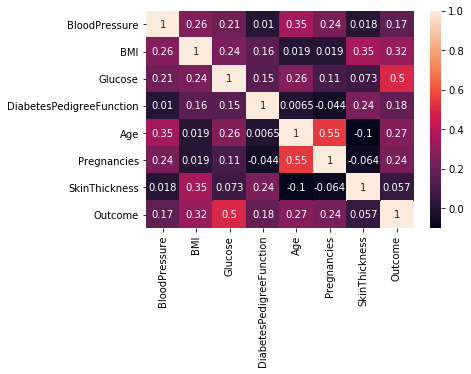

In [22]:
sns.heatmap(transformed(data).corr(), annot=True)

In [23]:
transformed(data)["Outcome"].value_counts()

1    563
0    500
Name: Outcome, dtype: int64

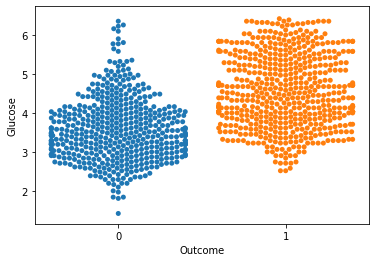

In [24]:
sns.swarmplot(transformed(data)["Outcome"], transformed(data)["Glucose"])

Outcome tends to be 0 statistically. We balance sample by adding copies of outcome 1

## Test data overview

In [25]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2d1e47240>,
      dtype=object)

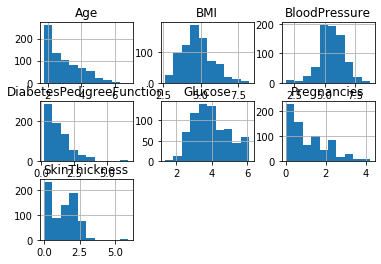

In [26]:
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train, y_train = preprocess_training_data(X_train_raw, y_train_raw)
features_pipeline().fit_transform(X_train).hist()

## Define model search functions

In [27]:
def logreg():
    from sklearn.linear_model import LogisticRegression

    pipeline = Pipeline([
        ("features", features_pipeline()),
        ("estimator", LogisticRegression(random_state=RANDOM_STATE, solver="lbfgs"))
    ])

    model = GridSearchCV(pipeline,
                         {"estimator__C": [0.01, 0.03, 0.06, 0.1, 0.15, 0.45, 1],
                          "estimator__tol": [1E-8, 1E-7, 1E-6, 1E-5],
                          "estimator__max_iter": [450, 500, 550]},
                          cv=3, scoring='f1', error_score='raise')
    model.fit(X_train, y_train)
    return model

In [28]:
def knn():
    from sklearn.neighbors import KNeighborsClassifier
    
    pipeline = Pipeline([
        ("features", features_pipeline()),
        ("estimator", KNeighborsClassifier())
    ])
    
    model = GridSearchCV(pipeline,
                         {"estimator__n_neighbors": [1,2,3,4,5, 7, 10, 50, 80],
                          "estimator__p": [1, 2]},
                         cv=3, scoring='f1', error_score='raise')
    model.fit(X_train, y_train)
    return model

In [29]:
def dectree():
    from sklearn.tree import DecisionTreeClassifier
    
    pipeline = Pipeline([
        ("features", features_pipeline()),
        ("estimator", DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])
    
    model = pipeline
    model.fit(X_train, y_train)
    return model

## Define `model`. Build report

In [30]:
model = logreg()

In [31]:
model_report(model, X_test, y_test)

Score: 0.6736842105263158
Confusion matrix:


array([[105,  40],
       [ 22,  64]])

Precision recall fscore support:


(array([0.82677165, 0.61538462]),
 array([0.72413793, 0.74418605]),
 array([0.77205882, 0.67368421]),
 array([145,  86]))

Model params


{'estimator__C': 0.15, 'estimator__max_iter': 450, 'estimator__tol': 1e-08}

All score-params:


,mean_test_score,std_test_score,param__estimator__C,param__estimator__max_iter,param__estimator__tol
0,0.765140,0.016421,0.01,450,1.000000e-08
1,0.765140,0.016421,0.01,450,1.000000e-07
2,0.765140,0.016421,0.01,450,1.000000e-06
3,0.765140,0.016421,0.01,450,1.000000e-05
4,0.765140,0.016421,0.01,500,1.000000e-08
5,0.765140,0.016421,0.01,500,1.000000e-07
6,0.765140,0.016421,0.01,500,1.000000e-06
7,0.765140,0.016421,0.01,500,1.000000e-05
8,0.765140,0.016421,0.01,550,1.000000e-08
9,0.765140,0.016421,0.01,550,1.000000e-07
